In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

In [3]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [4]:
data_kwargs = dict(sep="\t", names=["userid", "itemid", "rating", "timestamp"])
try:
    data = pd.read_csv("../../dataset/ml-100k/u.data", **data_kwargs)
except FileNotFoundError:
    data = pd.read_csv(pm.get_data("../../dataset/ml-100k/u.data"), **data_kwargs)

data.head()

,userid,itemid,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
# fmt: off
movie_columns  = ['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL', 
                  'unknown','Action','Adventure', 'Animation',"Children's", 'Comedy', 'Crime',
                  'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                  'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
# fmt: on

item_kwargs = dict(sep="|", names=movie_columns, index_col="movie id", parse_dates=["release date"])
try:
    movies = pd.read_csv("../../dataset/ml-100k/u.item", **item_kwargs, encoding='latin-1')
except FileNotFoundError:
    movies = pd.read_csv(pm.get_data("../../dataset/ml-100k/u.item"), **item_kwargs)

movies.head()

,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


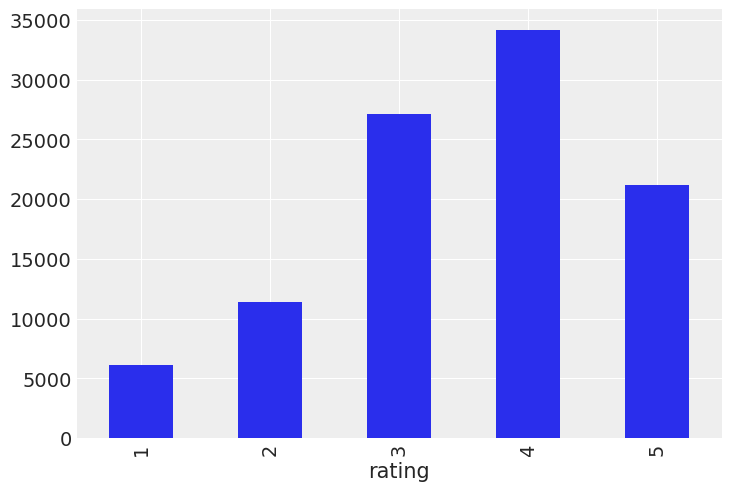

In [5]:
data.groupby("rating").size().plot(kind="bar");

/home/gegen07/micromamba/envs/pymc/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/home/gegen07/micromamba/envs/pymc/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


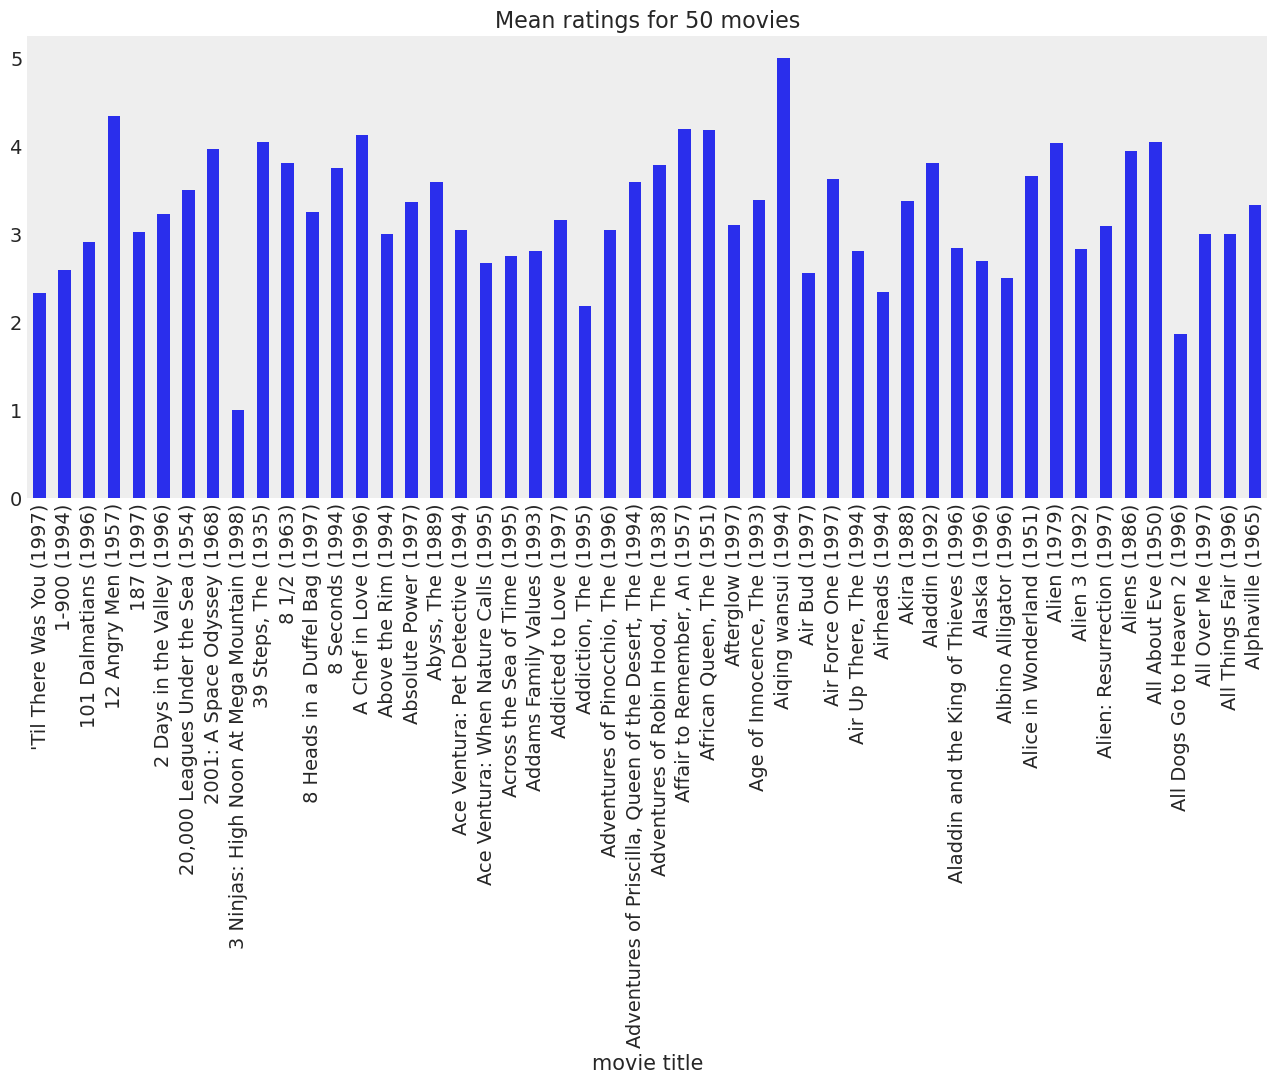

In [6]:
movie_means = data.join(movies["movie title"], on="itemid").groupby("movie title").rating.mean()
movie_means[:50].plot(kind="bar", grid=False, figsize=(16, 6), title="Mean ratings for 50 movies");

/home/gegen07/micromamba/envs/pymc/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/home/gegen07/micromamba/envs/pymc/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


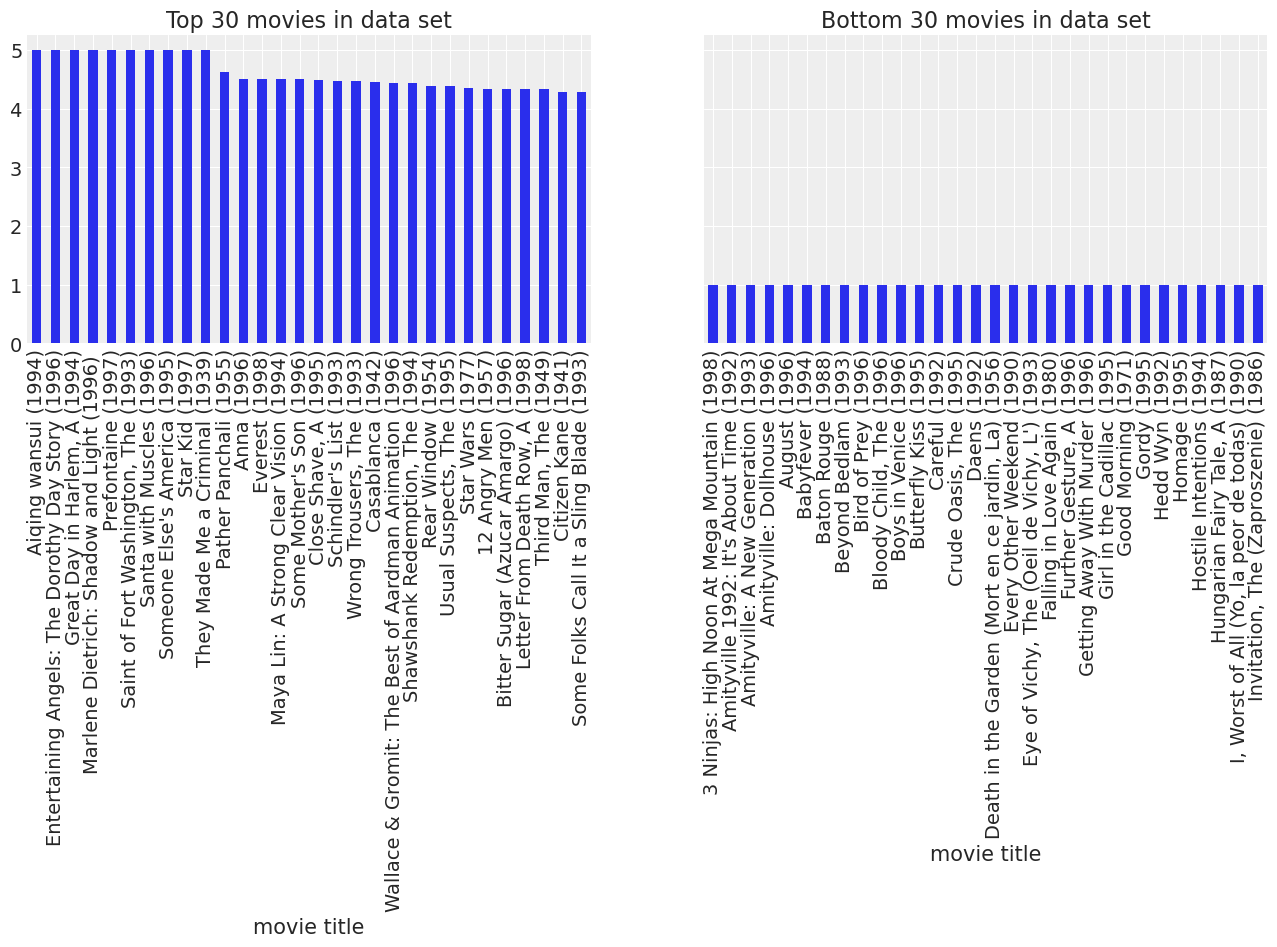

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4), sharey=True)
movie_means.nlargest(30).plot(kind="bar", ax=ax1, title="Top 30 movies in data set")
movie_means.nsmallest(30).plot(kind="bar", ax=ax2, title="Bottom 30 movies in data set");

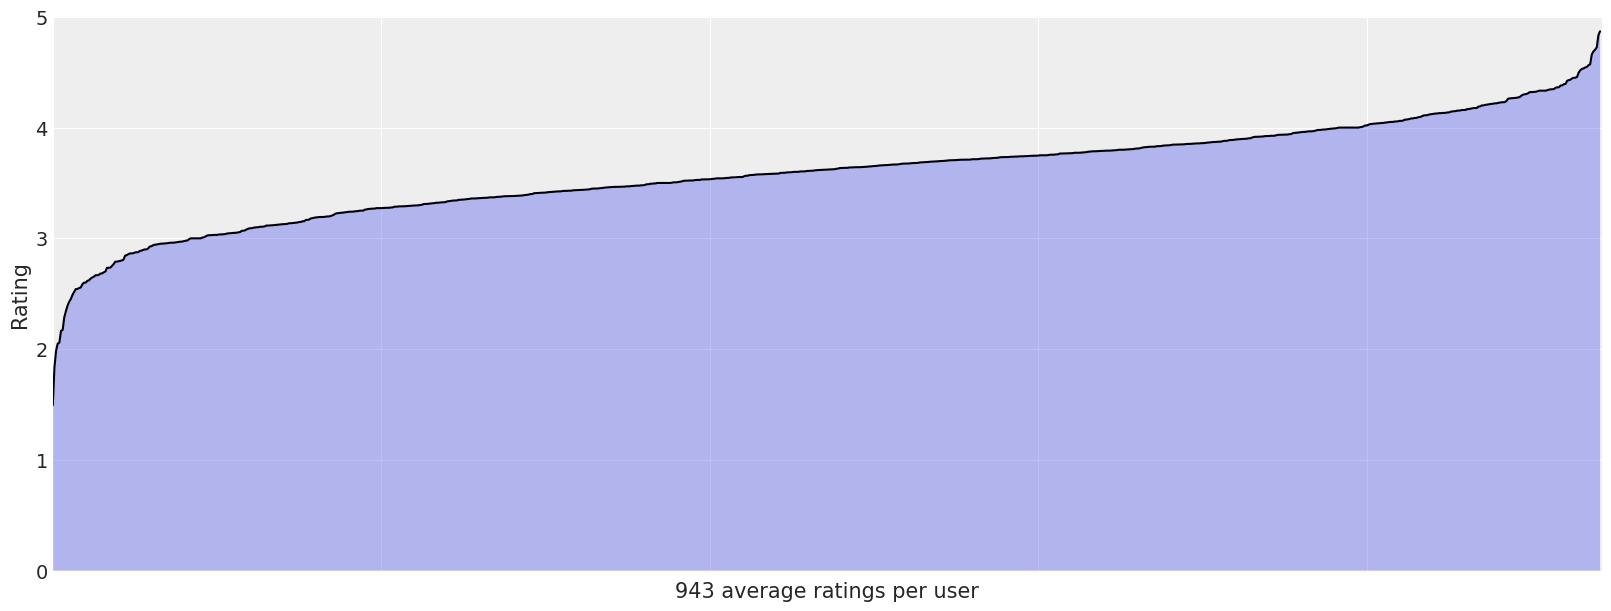

In [8]:
user_means = data.groupby("userid").rating.mean().sort_values()
_, ax = plt.subplots(figsize=(16, 6))
ax.plot(np.arange(len(user_means)), user_means.values, "k-")

ax.fill_between(np.arange(len(user_means)), user_means.values, alpha=0.3)
ax.set_xticklabels("")
# 1000 labels is nonsensical
ax.set_ylabel("Rating")
ax.set_xlabel(f"{len(user_means)} average ratings per user")
ax.set_ylim(0, 5)
ax.set_xlim(0, len(user_means));

### Models

In [9]:
def split_title(title):
    """Change "BaselineMethod" to "Baseline Method"."""
    words = []
    tmp = [title[0]]
    for c in title[1:]:
        if c.isupper():
            words.append("".join(tmp))
            tmp = [c]
        else:
            tmp.append(c)
    words.append("".join(tmp))
    return " ".join(words)


class Baseline:
    """Calculate baseline predictions."""

    def __init__(self, train_data):
        """Simple heuristic-based transductive learning to fill in missing
        values in data matrix."""
        self.predict(train_data.copy())

    def predict(self, train_data):
        raise NotImplementedError("baseline prediction not implemented for base class")

    def rmse(self, test_data):
        """Calculate root mean squared error for predictions on test data."""
        return rmse(test_data, self.predicted)

    def __str__(self):
        return split_title(self.__class__.__name__)


# Implement the 3 baselines.


class UniformRandomBaseline(Baseline):
    """Fill missing values with uniform random values."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        pmin, pmax = masked_train.min(), masked_train.max()
        N = nan_mask.sum()
        train_data[nan_mask] = rng.uniform(pmin, pmax, N)
        self.predicted = train_data


class GlobalMeanBaseline(Baseline):
    """Fill in missing values using the global mean."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        train_data[nan_mask] = train_data[~nan_mask].mean()
        self.predicted = train_data


class MeanOfMeansBaseline(Baseline):
    """Fill in missing values using mean of user/item/global means."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        global_mean = masked_train.mean()
        user_means = masked_train.mean(axis=1)
        item_means = masked_train.mean(axis=0)
        self.predicted = train_data.copy()
        n, m = train_data.shape
        for i in range(n):
            for j in range(m):
                if np.ma.isMA(item_means[j]):
                    self.predicted[i, j] = np.mean((global_mean, user_means[i]))
                else:
                    self.predicted[i, j] = np.mean((global_mean, user_means[i], item_means[j]))


baseline_methods = {}
baseline_methods["ur"] = UniformRandomBaseline
baseline_methods["gm"] = GlobalMeanBaseline
baseline_methods["mom"] = MeanOfMeansBaseline

In [15]:
num_users = data.userid.unique().shape[0]
num_items = data.itemid.unique().shape[0]
sparsity = 1 - len(data) / (num_users * num_items)
print(f"Users: {num_users}\nMovies: {num_items}\nSparsity: {sparsity}")

dense_data = data.pivot(index="userid", columns="itemid", values="rating").values

Users: 943
Movies: 1682
Sparsity: 0.9369533063577546


In [11]:
import logging
import time

import pytensor
import scipy as sp

# Enable on-the-fly graph computations, but ignore
# absence of intermediate test values.
pytensor.config.compute_test_value = "ignore"

# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)


class PMF:
    """Probabilistic Matrix Factorization model using pymc."""

    def __init__(self, train, dim, alpha=2, std=0.01, bounds=(1, 5)):
        """Build the Probabilistic Matrix Factorization model using pymc.

        :param np.ndarray train: The training data to use for learning the model.
        :param int dim: Dimensionality of the model; number of latent factors.
        :param int alpha: Fixed precision for the likelihood function.
        :param float std: Amount of noise to use for model initialization.
        :param (tuple of int) bounds: (lower, upper) bound of ratings.
            These bounds will simply be used to cap the estimates produced for R.

        """
        self.dim = dim
        self.alpha = alpha
        self.std = np.sqrt(1.0 / alpha)
        self.bounds = bounds
        self.data = train.copy()
        n, m = self.data.shape

        # Perform mean value imputation
        nan_mask = np.isnan(self.data)
        self.data[nan_mask] = self.data[~nan_mask].mean()

        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = 1 / self.data.var(axis=1).mean()
        self.alpha_v = 1 / self.data.var(axis=0).mean()

        # Specify the model.
        logging.info("building the PMF model")
        with pm.Model(
            coords={
                "users": np.arange(n),
                "movies": np.arange(m),
                "latent_factors": np.arange(dim),
                "obs_id": np.arange(self.data[~nan_mask].shape[0]),
            }
        ) as pmf:
            U = pm.MvNormal(
                "U",
                mu=0,
                tau=self.alpha_u * np.eye(dim),
                dims=("users", "latent_factors"),
                initval=rng.standard_normal(size=(n, dim)) * std,
            )
            V = pm.MvNormal(
                "V",
                mu=0,
                tau=self.alpha_v * np.eye(dim),
                dims=("movies", "latent_factors"),
                initval=rng.standard_normal(size=(m, dim)) * std,
            )
            R = pm.Normal(
                "R",
                mu=(U @ V.T)[~nan_mask],
                tau=self.alpha,
                dims="obs_id",
                observed=self.data[~nan_mask],
            )

        logging.info("done building the PMF model")
        self.model = pmf

    def __str__(self):
        return self.name

In [12]:
def _find_map(self):
    """Find mode of posterior using L-BFGS-B optimization."""
    tstart = time.time()
    with self.model:
        logging.info("finding PMF MAP using L-BFGS-B optimization...")
        # start = pm.find_initial_point(vars=self.model.free_RVs)
        self._map = pm.find_MAP(method="L-BFGS-B")

    elapsed = int(time.time() - tstart)
    logging.info("found PMF MAP in %d seconds" % elapsed)
    return self._map


def _map(self):
    try:
        return self._map
    except:
        return self.find_map()


# Update our class with the new MAP infrastructure.
PMF.find_map = _find_map
PMF.map = property(_map)


In [13]:
def _draw_samples(self, **kwargs):
    # kwargs.setdefault("chains", 1)
    with self.model:
        self.trace = pm.sample(**kwargs)


# Update our class with the sampling infrastructure.
PMF.draw_samples = _draw_samples

In [14]:
def _predict(self, U, V):
    """Estimate R from the given values of U and V."""
    R = np.dot(U, V.T)
    sample_R = rng.normal(R, self.std)
    # bound ratings
    low, high = self.bounds
    sample_R[sample_R < low] = low
    sample_R[sample_R > high] = high
    return sample_R


PMF.predict = _predict

In [15]:
def rmse(test_data, predicted):
    """Calculate root mean squared error.
    Ignoring missing values in the test data.
    """
    I = ~np.isnan(test_data)  # indicator for missing values
    N = I.sum()  # number of non-missing values
    sqerror = abs(test_data - predicted) ** 2  # squared error array
    print(sqerror.shape, I.shape)
    mse = sqerror[I].sum() / N  # mean squared error
    return np.sqrt(mse)  # RMSE

In [16]:
def split_train_test(data, percent_test=0.1):
    """Split the data into train/test sets.
    :param int percent_test: Percentage of data to use for testing. Default 10.
    """
    n, m = data.shape  # # users, # movies
    N = n * m  # # cells in matrix

    # Prepare train/test ndarrays.
    train = data.copy()
    test = np.ones(data.shape) * np.nan

    # Draw random sample of training data to use for testing.
    tosample = np.where(~np.isnan(train))  # ignore nan values in data
    idx_pairs = list(zip(tosample[0], tosample[1]))  # tuples of row/col index pairs

    test_size = int(len(idx_pairs) * percent_test)  # use 10% of data as test set
    train_size = len(idx_pairs) - test_size  # and remainder for training

    indices = np.arange(len(idx_pairs))  # indices of index pairs
    sample = rng.choice(indices, replace=False, size=test_size)

    # Transfer random sample from train set to test set.
    for idx in sample:
        idx_pair = idx_pairs[idx]
        test[idx_pair] = train[idx_pair]  # transfer to test set
        train[idx_pair] = np.nan  # remove from train set

    # Verify everything worked properly
    assert train_size == N - np.isnan(train).sum()
    assert test_size == N - np.isnan(test).sum()

    # Return train set and test set
    return train, test

dense_data = data.pivot(index="userid", columns="itemid", values="rating").values
train, test = split_train_test(dense_data)

In [17]:
baselines = {}
for name in baseline_methods:
    Method = baseline_methods[name]
    method = Method(train)
    baselines[name] = method.rmse(test)
    print("{} RMSE:\t{:.5f}".format(method, baselines[name]))

(943, 1682) (943, 1682)
Uniform Random Baseline RMSE:	1.68490
(943, 1682) (943, 1682)
Global Mean Baseline RMSE:	1.11492
(943, 1682) (943, 1682)
Mean Of Means Baseline RMSE:	1.00750


In [18]:
# We use a fixed precision for the likelihood.
# This reflects uncertainty in the dot product.
# We choose 2 in the footsteps Salakhutdinov
# Mnihof.
ALPHA = 2

# The dimensionality D; the number of latent factors.
# We can adjust this higher to try to capture more subtle
# characteristics of each movie. However, the higher it is,
# the more expensive our inference procedures will be.
# Specifically, we have D(N + M) latent variables. For our
# Movielens dataset, this means we have D(2625), so for 5
# dimensions, we are sampling 13125 latent variables.
DIM = 10


pmf = PMF(train, DIM, ALPHA, std=0.05)

INFO:root:building the PMF model
INFO:root:done building the PMF model


In [19]:
pmf.find_map()

INFO:root:finding PMF MAP using L-BFGS-B optimization...


Output()

INFO:root:found PMF MAP in 29 seconds


{'U': array([[-0.18511573,  0.97649398, -0.91662726, ...,  0.53394341,
          0.07682957,  1.32272444],
        [-0.24276201,  0.60461934, -0.71299816, ...,  0.27030336,
          0.75912797,  0.9084981 ],
        [ 0.19258228,  0.68127333, -0.24454676, ..., -0.08546081,
          0.14976651,  0.84036586],
        ...,
        [ 0.12106402,  0.57919863, -0.17658052, ...,  0.19057648,
          0.48577034,  0.76039503],
        [ 0.62426503,  0.96828061, -0.42115696, ..., -0.25177755,
          1.16411363,  1.08000081],
        [ 0.57084407,  0.75249207, -0.03486849, ..., -0.90952644,
          0.54014997,  0.42651443]]),
 'V': array([[-0.15960743,  0.77090894,  0.05376411, ..., -0.19356991,
          0.89234819,  0.76606455],
        [ 0.16295612,  0.78966606,  0.01152728, ..., -0.00312815,
          0.9648062 ,  0.81036145],
        [ 0.65072319,  0.10190107, -0.36793849, ..., -0.41699222,
          0.5188591 ,  1.06776734],
        ...,
        [ 0.06476585,  0.01173055, -0.119157

In [20]:
def eval_map(pmf_model, train, test):
    U = pmf_model.map["U"]
    V = pmf_model.map["V"]
    # Make predictions and calculate RMSE on train & test sets.
    predictions = pmf_model.predict(U, V)
    train_rmse = rmse(train, predictions)
    test_rmse = rmse(test, predictions)
    overfit = test_rmse - train_rmse

    # Print report.
    print("PMF MAP training RMSE: %.5f" % train_rmse)
    print("PMF MAP testing RMSE:  %.5f" % test_rmse)
    print("Train/test difference: %.5f" % overfit)

    return test_rmse


# Add eval function to PMF class.
PMF.eval_map = eval_map

In [21]:
pmf_map_rmse = pmf.eval_map(train, test)
pmf_improvement = baselines["mom"] - pmf_map_rmse
print("PMF MAP Improvement:   %.5f" % pmf_improvement)

(943, 1682) (943, 1682)
(943, 1682) (943, 1682)
PMF MAP training RMSE: 1.01558
PMF MAP testing RMSE:  1.13146
Train/test difference: 0.11588
PMF MAP Improvement:   -0.12396


In [22]:
print(train.shape, test.shape)

(943, 1682) (943, 1682)


In [51]:
pmf.draw_samples(draws=100, tune=100)

Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [U, V]
INFO:pymc.sampling.mcmc:NUTS: [U, V]


Output()

Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 880 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 880 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [23]:
def _norms(pmf_model):
    """Return norms of latent variables at each step in the
    sample trace. These can be used to monitor convergence
    of the sampler.
    """

    norms = dict()
    norms["U"] = xr.apply_ufunc(
        np.linalg.norm,
        pmf_model.trace.posterior["U"],
        input_core_dims=[["users", "latent_factors"]],
        kwargs={"ord": "fro", "axis": (-2, -1)},
    )
    norms["V"] = xr.apply_ufunc(
        np.linalg.norm,
        pmf_model.trace.posterior["V"],
        input_core_dims=[["movies", "latent_factors"]],
        kwargs={"ord": "fro", "axis": (-2, -1)},
    )

    return xr.Dataset(norms)


def _traceplot(pmf_model):
    """Plot Frobenius norms of U and V as a function of sample #."""
    fig, ax = plt.subplots(2, 2, figsize=(12, 7))
    az.plot_trace(pmf_model.norms(), axes=ax)
    ax[0][1].set_title(label=r"$\|U\|_{Fro}^2$ at Each Sample", fontsize=10)
    ax[1][1].set_title(label=r"$\|V\|_{Fro}^2$ at Each Sample", fontsize=10)
    ax[1][1].set_xlabel("Sample Number", fontsize=10)


PMF.norms = _norms
PMF.traceplot = _traceplot

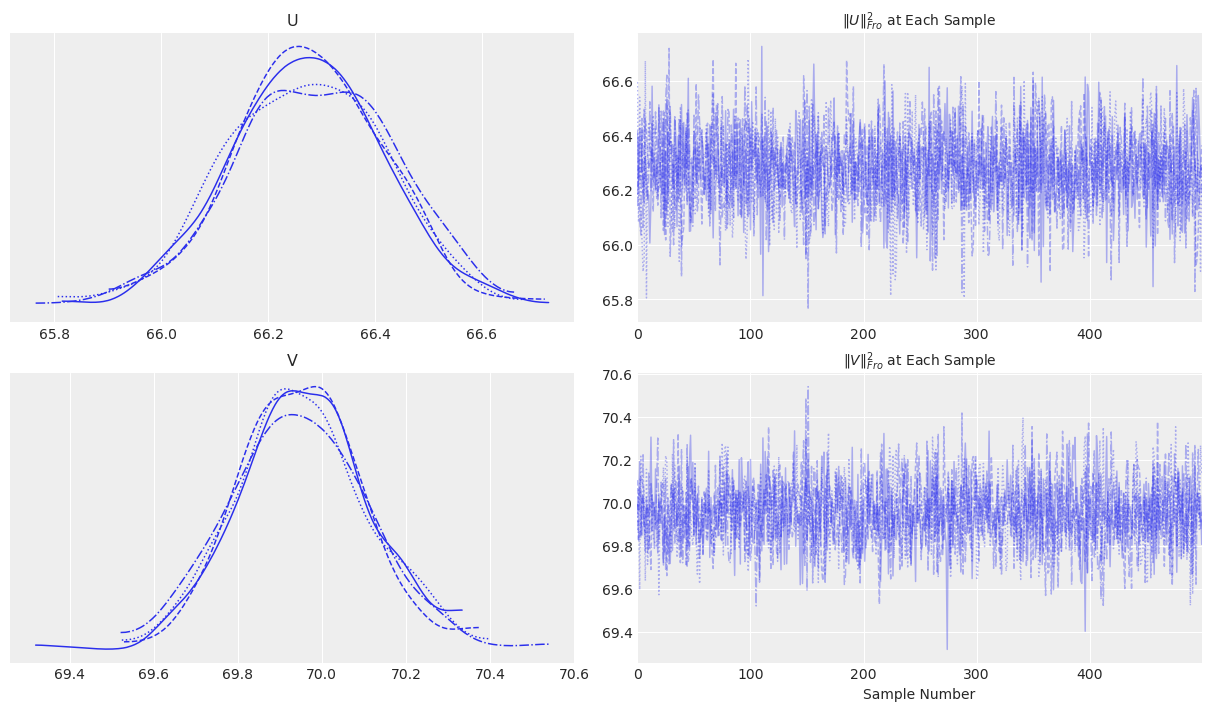

In [24]:
pmf.traceplot()


In [25]:
def _running_rmse(pmf_model, test_data, train_data, plot=True):
    """Calculate RMSE for each step of the trace to monitor convergence."""
    results = {"per-step-train": [], "running-train": [], "per-step-test": [], "running-test": []}
    R = np.zeros(test_data.shape)
    for cnt in pmf.trace.posterior.draw.values:
        U = pmf_model.trace.posterior["U"].sel(chain=0, draw=cnt)
        V = pmf_model.trace.posterior["V"].sel(chain=0, draw=cnt)
        sample_R = pmf_model.predict(U, V)
        R += sample_R
        running_R = R / (cnt + 1)
        results["per-step-train"].append(rmse(train_data, sample_R))
        results["running-train"].append(rmse(train_data, running_R))
        results["per-step-test"].append(rmse(test_data, sample_R))
        results["running-test"].append(rmse(test_data, running_R))

    results = pd.DataFrame(results)

    if plot:
        results.plot(
            kind="line",
            grid=False,
            figsize=(15, 7),
            title="Per-step and Running RMSE From Posterior Predictive",
        )

    # Return the final predictions, and the RMSE calculations
    return running_R, results


PMF.running_rmse = _running_rmse

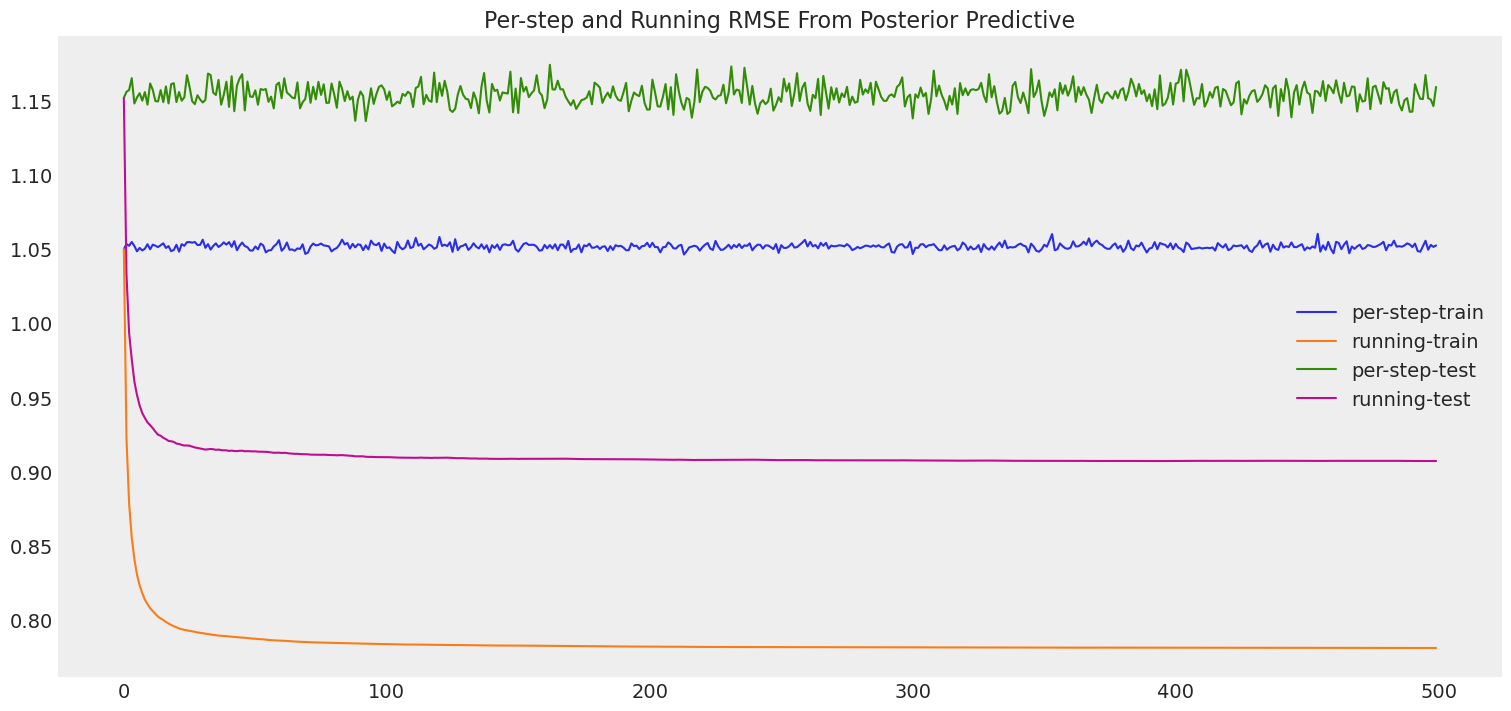

In [26]:
predicted, results = pmf.running_rmse(test, train)


In [27]:
final_test_rmse = results["running-test"].values[-1]
final_train_rmse = results["running-train"].values[-1]
print("Posterior predictive train RMSE: %.5f" % final_train_rmse)
print("Posterior predictive test RMSE:  %.5f" % final_test_rmse)
print("Train/test difference:           %.5f" % (final_test_rmse - final_train_rmse))
print("Improvement from MAP:            %.5f" % (pmf_map_rmse - final_test_rmse))
print("Improvement from Mean of Means:  %.5f" % (baselines["mom"] - final_test_rmse))

Posterior predictive train RMSE: 0.78100
Posterior predictive test RMSE:  0.90710
Train/test difference:           0.12610
Improvement from MAP:            0.22436
Improvement from Mean of Means:  0.10040


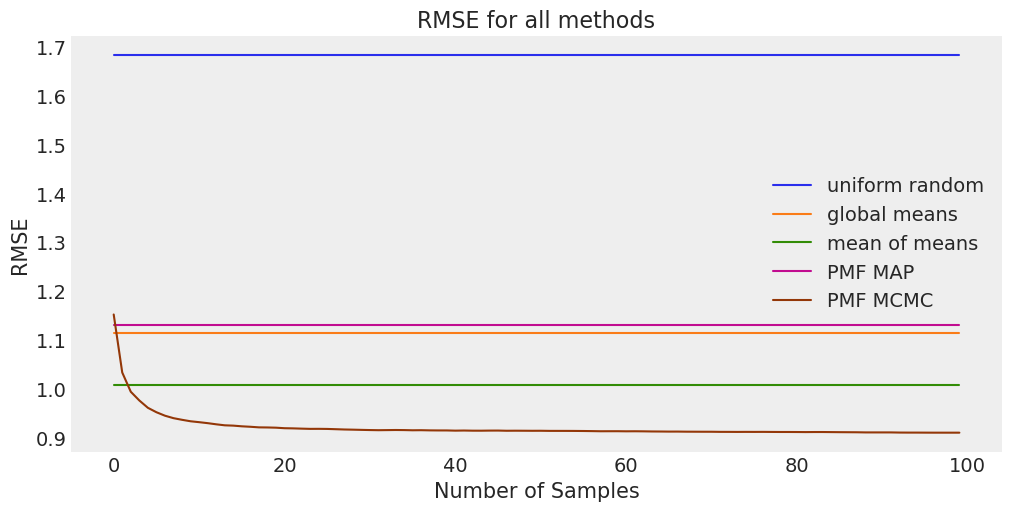

In [28]:
size = 100  # RMSE doesn't really change after 100th sample anyway.
all_results = pd.DataFrame(
    {
        "uniform random": np.repeat(baselines["ur"], size),
        "global means": np.repeat(baselines["gm"], size),
        "mean of means": np.repeat(baselines["mom"], size),
        "PMF MAP": np.repeat(pmf_map_rmse, size),
        "PMF MCMC": results["running-test"][:size],
    }
)
fig, ax = plt.subplots(figsize=(10, 5))
all_results.plot(kind="line", grid=False, ax=ax, title="RMSE for all methods")
ax.set_xlabel("Number of Samples")
ax.set_ylabel("RMSE");

In [33]:
pmf.trace.posterior.draw.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [46]:
U = pmf.trace.posterior["U"].sel(chain=1, draw=49)
V = pmf.trace.posterior["V"].sel(chain=1, draw=49)
R = pmf.predict(U, V)

In [47]:
R

array([[4.569326  , 1.86025744, 4.19397721, ..., 1.        , 1.        ,
        1.76739424],
       [4.87917991, 3.14671712, 2.72850773, ..., 1.        , 1.        ,
        1.05342911],
       [2.77891929, 1.13109126, 1.539427  , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [4.2407543 , 2.50177745, 3.336855  , ..., 1.        , 1.        ,
        1.68910807],
       [5.        , 3.16324863, 3.20140561, ..., 1.        , 1.        ,
        2.44247721],
       [4.08373401, 3.77079027, 3.36380517, ..., 1.        , 1.        ,
        1.8816595 ]])

<Axes: title={'center': 'x'}>

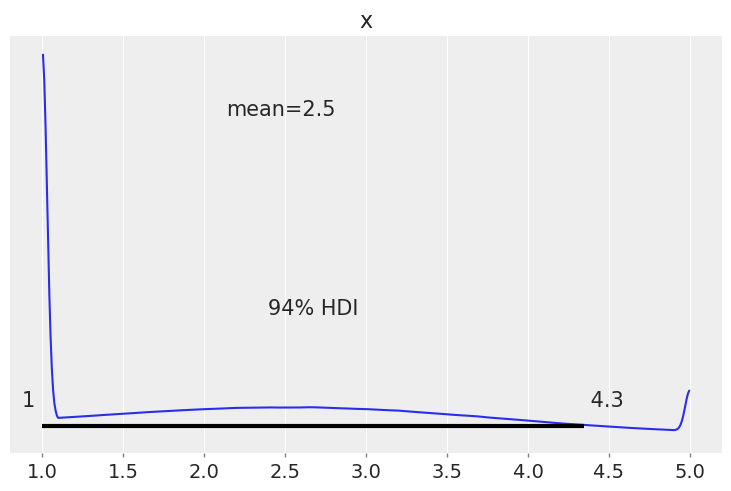

In [48]:
az.plot_posterior(R)

<Axes: title={'center': 'x'}>

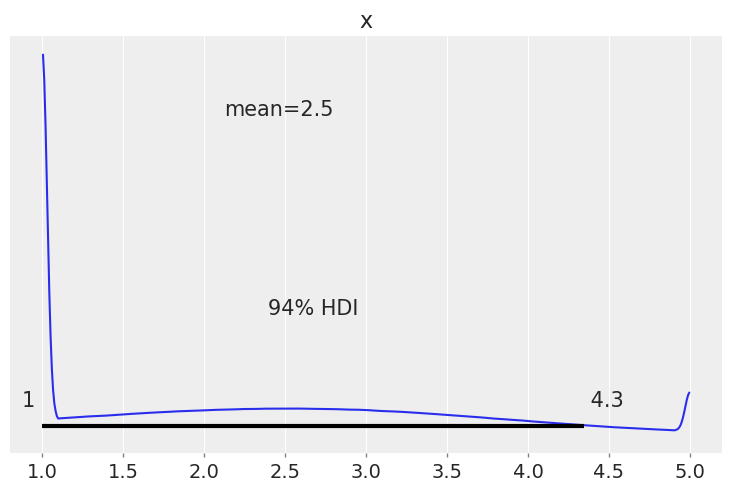

In [52]:
U = pmf.trace.posterior["U"].sel(chain=1, draw=99)
V = pmf.trace.posterior["V"].sel(chain=1, draw=99)
R = pmf.predict(U, V)
az.plot_posterior(R)